In [8]:
from collections import Counter
import numpy as np
import pandas as pd
import Levenshtein  # pip install python-Levenshtein
import re

In [9]:
import pandas as pd

# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Prevent truncating column content
pd.set_option('display.max_colwidth', None)  # For pandas < 1.0 use -1 instead of None


In [10]:
data = pd.read_csv('df_f_1.csv')

In [11]:
data.head(10)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,7/31/2019,1x Dual Sim,Alcatel 1x Dual Sim,alcatel,Google,Android,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,nan,Non-Saudi,4
1,3/31/2019,K7 Dual Sim,LG K7 Dual Sim,NaN,Google,Android,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1
2,11/30/2019,ELUGA I3,Panasonic ELUGA I3,Panasonic,Google,Androxd,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1
3,8/31/2019,M98,HEDY M98,hedy,HEDY,Proprietary,Mobile Phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3
4,12/31/2019,|105,NaN,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,NaN,N,Male,NA,IND,India,Non-Saudi,3758
5,1/31/2020,One Touch 1050 Dual Sim,Alcatel One Touch 1050 Dual Sim,ALCATEL,Alcatel,Proprietary,Mobile Phone,Y,N,N,N,N,N,Y,Male,36-55,BHR,Bahrain,Non-Saudi,1
6,NaN,Moto M# Dual Sim,Motorola Moto M Dual Sim,MOTOROLA,Google,Androiy,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,SYR,Syria,Non-Saudi,1
7,2/29/2020,K802,Kaliho K802,kaliho,Google,Android,Smartphone,Y,Y,N,NaN,Y,Y,Y,Male,18-25,IDN,Indonesia,Non-Saudi,1
8,1/31/2019,T528,Tecno T528,tecno,Tecno Technology,NaN,Mobile Phone,Y,N,N,N,NaN,N,Y,Male,NaN,NGA,Nigerian,Non-Saudi,14
9,12/31/2019,2310,Nokia 2310,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,N,N,Female,36-55,PHL,Philippines,Non-Saudi,5


In [12]:
df=data.copy()

In [13]:
df['BLUETOOTH_FLG'].value_counts()

BLUETOOTH_FLG
Y    171484
N     18155
Z       329
Name: count, dtype: int64

# Misspelling Fix

In [14]:
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Standardize the flag values
for col in flag_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        'y': 'Y', 'yes': 'Y',
        'n': 'N', 'no': 'N'
    }).fillna(df[col])


In [15]:
df['DEVICE_COUNT'] = df['DEVICE_COUNT'].replace('ten', 10)


In [16]:
def clean_text(val):
    if isinstance(val, str):
        return re.sub(r'\s+', ' ', val.strip())
    return val

df = df.applymap(clean_text)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\2268659357.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)


In [17]:
cols_to_lower = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_lower:
    df[col] = df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [18]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\490592483.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [19]:
cols_to_clean = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' | ', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' |', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('|', '', regex=False)


# Step 1: Remove unwanted characters (except parentheses)
symbol_pattern = r"[!@#$%^&*_={};:'\"<>,.?/\\|`~]"  # Adjusted to include more symbols

# Step 2: Remove unmatched ( or )
def remove_unmatched_parens(text):
    if not isinstance(text, str):
        return text

    # Count opening and closing
    open_count = text.count('(')
    close_count = text.count(')')

    # If unmatched '(', remove it
    if open_count > close_count:
        text = text.replace('(', '')
    # If unmatched ')', remove it
    if close_count > open_count:
        text = text.replace(')', '')

    return text

# Apply both cleaning steps
for col in cols_to_clean:
    df[col] = df[col].apply(lambda x: re.sub(symbol_pattern, '', x) if isinstance(x, str) else x)
    df[col] = df[col].apply(remove_unmatched_parens)


In [20]:
# Cleaning function: remove '+' only if not at the end
def clean_plus(text):
    if isinstance(text, str):
        return re.sub(r'\+(?=\w)', '', text)
    return text

# Apply the function to each column
for col in cols_to_lower:
    df[col] = df[col].apply(clean_plus)

In [21]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


# Correct Names

In [22]:
from collections import Counter
import Levenshtein

def correct_similar_values(df, column, max_distance=2):
    print(f"Cleaning column: '{column}'")

    # Step 1: Drop NaNs and prepare the value list
    values = df[column].dropna().astype(str).str.strip()
    frequencies = Counter(values)
    unique_values = list(frequencies.keys())
    visited = set()
    corrections = {}

    # Step 2: Compare all pairs to find similar groups
    for i, val1 in enumerate(unique_values):
        if val1 in visited:
            continue
        group = [val1]
        for val2 in unique_values[i+1:]:
            if val2 in visited:
                continue
            if Levenshtein.distance(val1.lower(), val2.lower()) <= max_distance:
                group.append(val2)
                visited.add(val2)
        visited.add(val1)

        # Pick the most frequent value in the group
        if len(group) > 1:
            canonical = max(group, key=lambda x: frequencies[x])
            for val in group:
                if val != canonical:
                    corrections[val] = canonical

    # Step 3: Apply corrections
    df_cleaned = df.copy()
    df_cleaned[column] = df_cleaned[column].apply(lambda x: corrections.get(x, x) if isinstance(x, str) else x)

    print(f"Unique values reduced: {df[column].nunique()} → {df_cleaned[column].nunique()}")
    return df_cleaned, corrections

In [23]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4
1,3/31/2019,k7 dual sim,lg k7 dual sim,NaN,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,androxd,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3
4,12/31/2019,105,NaN,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758


In [24]:
columns_to_fix = ['NATIONALITY_NAME', 'SAUDI_NON_SAUDI', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'BRAND_NAME']

for col in columns_to_fix:
    df, fixes = correct_similar_values(df, column=col)

Cleaning column: 'NATIONALITY_NAME'
Unique values reduced: 1595 → 206
Cleaning column: 'SAUDI_NON_SAUDI'
Unique values reduced: 2 → 2
Cleaning column: 'VENDOR_NAME'
Unique values reduced: 845 → 107
Cleaning column: 'OS_NAME'
Unique values reduced: 201 → 9
Cleaning column: 'DEVICE_TYPE'
Unique values reduced: 2 → 2
Cleaning column: 'BRAND_NAME'
Unique values reduced: 1171 → 170


In [25]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
uyknown               37
windows mobile        34
Name: count, dtype: int64

In [26]:
# Fix the logic to correctly replace 'uyknown' with 'unknown' in OS_NAME
df.loc[df['OS_NAME'] == 'uyknown', 'OS_NAME'] = 'unknown'

In [27]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
unknown               37
windows mobile        34
Name: count, dtype: int64

In [28]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [29]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [30]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               59911
htc                 13683
lenovo              12380
lg                  10697
sony                 9811
xiaomi               9779
alcatel              8860
oppo                 5991
vivo                 4897
lava                 4796
tecno                4592
motorola             4473
panasonic            4078
oneplus              2863
four                 2730
infinix              2662
rim                  1952
mione                1748
asus                 1628
symphony             1591
philips              1547
blackberry           1517
microsoft            1077
bocoin                975
micromax              972
innjoo                971
darago                720
google                629
sony ericsson         610
star                  551
qmobile               526
eurostar  device      511
obi                   419
realme                411
xtouch                397
iku                   350
hope                  331
fero                  324
e

In [31]:
# Define the corrections
brand_corrections = {
    'cecz': 'cect',
    'hzc': 'htc',
    'ityl': 'itzl',
    'miyne': 'mione',
    'mphzne': 'mphone',
    'sict': 'sico',
    'wyko': 'wiko',
    'xltzl': 'xltel'
}

# Apply corrections to the 'BRAND_NAME' column
df['BRAND_NAME'] = df['BRAND_NAME'].replace(brand_corrections)


In [32]:
df['VENDOR_NAME'] = df['VENDOR_NAME'].replace(r'(?i)^goo$', 'google', regex=True)

# Outliers

In [33]:
df.DEVICE_COUNT.head().value_counts()

DEVICE_COUNT
1       2
4       1
3       1
3758    1
Name: count, dtype: int64

In [34]:
data['DEVICE_COUNT'].isna().sum()

np.int64(12052)

In [35]:
#Because there was 'ten' string
df['DEVICE_COUNT'] = pd.to_numeric(df['DEVICE_COUNT'], errors='coerce').astype('Int64')

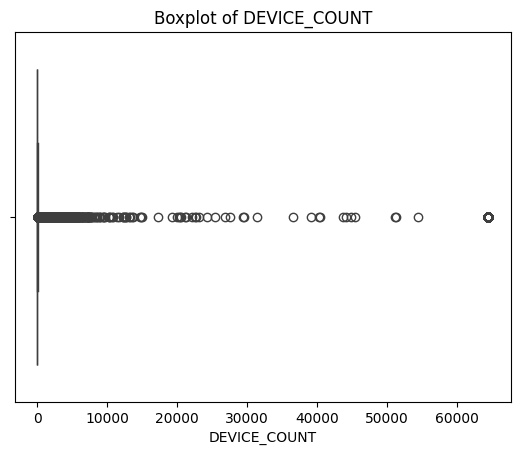

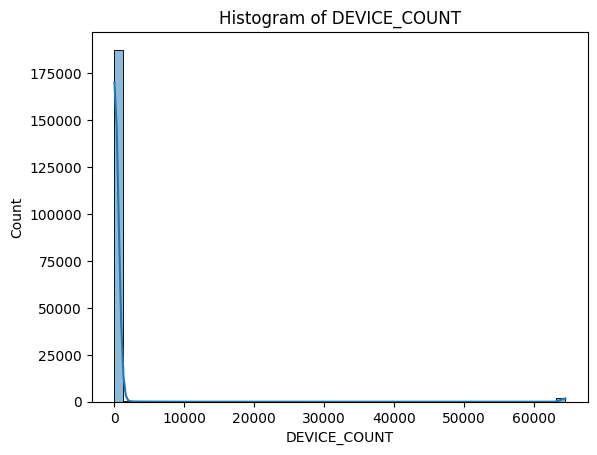

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df['DEVICE_COUNT'])
plt.title("Boxplot of DEVICE_COUNT")
plt.show()

sns.histplot(df['DEVICE_COUNT'], bins=50, kde=True)
plt.title("Histogram of DEVICE_COUNT")
plt.show()


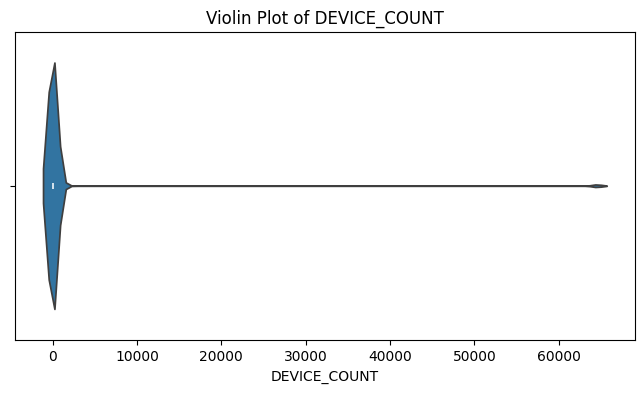

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.violinplot(x=df['DEVICE_COUNT'])
plt.title("Violin Plot of DEVICE_COUNT")
plt.xlabel("DEVICE_COUNT")
plt.show()

In [38]:
Q1 = df['DEVICE_COUNT'].quantile(0.25)
Q3 = df['DEVICE_COUNT'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['DEVICE_COUNT'] < lower_bound) | (df['DEVICE_COUNT'] > upper_bound)]
print(f"Outliers found: {len(outliers)}")


Outliers found: 28285


In [39]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [40]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [41]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               59911
htc                 13877
lenovo              12380
lg                  10697
sony                 9811
xiaomi               9779
alcatel              8860
oppo                 5991
vivo                 4897
lava                 4796
tecno                4592
motorola             4473
panasonic            4078
oneplus              2863
four                 2730
infinix              2662
rim                  1952
mione                1784
asus                 1628
symphony             1591
philips              1547
blackberry           1517
microsoft            1077
bocoin                975
micromax              972
innjoo                971
darago                720
google                629
sony ericsson         610
star                  551
qmobile               526
eurostar  device      511
obi                   419
realme                411
xtouch                397
iku                   350
hope                  331
fero                  324
e

In [42]:
from sklearn.preprocessing import RobustScaler

def replace_outliers_with_scaled_safe(data, outlier_method='iqr'):
    """
    Apply RobustScaler with data cleaning and outlier replacement
    """
    # Clean data first
    clean_data = pd.to_numeric(data, errors='coerce')
    
    # Remove NaN values for processing
    valid_mask = clean_data.notna()
    valid_data = clean_data[valid_mask]
    
    if len(valid_data) == 0:
        return data.copy(), pd.Series(False, index=data.index)
    
    # Step 1: Identify outliers
    if outlier_method == 'iqr':
        Q1 = valid_data.quantile(0.25)
        Q3 = valid_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (valid_data < lower_bound) | (valid_data > upper_bound)
    
    elif outlier_method == 'zscore':
        z_scores = np.abs((valid_data - valid_data.mean()) / valid_data.std())
        outlier_mask = z_scores > 3
    
    # Step 2: Apply RobustScaler to valid data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(valid_data.values.reshape(-1, 1)).flatten()
    
    # Step 3: Create result
    result = clean_data.copy()
    result[valid_mask] = valid_data  # Keep original non-outliers
    result = result.astype(float)  # Add this before assignment
    result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers
    
    return result, outlier_mask

# Usage
df['DEVICE_COUNT_processed'], outliers_mask = replace_outliers_with_scaled_safe(df['DEVICE_COUNT'])

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\2363318935.py:38: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202000 entries, 0 to 201999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CAL_DT                  189965 non-null  object 
 1   MODEL_NAME              189955 non-null  object 
 2   BRAND_FULL_NAME         189949 non-null  object 
 3   BRAND_NAME              189952 non-null  object 
 4   VENDOR_NAME             189067 non-null  object 
 5   OS_NAME                 189029 non-null  object 
 6   DEVICE_TYPE             189909 non-null  object 
 7   _2G_FLG                 189935 non-null  object 
 8   _3G_FLG                 189939 non-null  object 
 9   _4G_FLG                 189927 non-null  object 
 10  WIFI_FLG                189946 non-null  object 
 11  BLUETOOTH_FLG           189968 non-null  object 
 12  TOUCH_SCREEN_FLG        189945 non-null  object 
 13  DUAL_SIM_FLG            189955 non-null  object 
 14  GENDER_TYPE_CD      

In [44]:
# Now this should work
print("Outliers before and after:")
threshold = df['DEVICE_COUNT_processed'].quantile(0.95)
outliers_mask = (df['DEVICE_COUNT_processed'] > threshold)

comparison = pd.DataFrame({
    'Original': df['DEVICE_COUNT'].head(10),
    'Processed': df['DEVICE_COUNT_processed'].head(10)
})
print(comparison)

Outliers before and after:
   Original  Processed
0         4        4.0
1         1        1.0
2         1        1.0
3         3        3.0
4      3758      626.0
5         1        1.0
6         1        1.0
7         1        1.0
8        14       14.0
9         5        5.0


# Fill null

In [45]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,NaN,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,3.0
4,12/31/2019,105,NaN,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,626.0


In [46]:
df.isna().sum()

CAL_DT                    12035
MODEL_NAME                12045
BRAND_FULL_NAME           12051
BRAND_NAME                12048
VENDOR_NAME               12933
OS_NAME                   12971
DEVICE_TYPE               12091
_2G_FLG                   12065
_3G_FLG                   12061
_4G_FLG                   12073
WIFI_FLG                  12054
BLUETOOTH_FLG             12032
TOUCH_SCREEN_FLG          12055
DUAL_SIM_FLG              12045
GENDER_TYPE_CD            34642
AGE_B                     41312
NATIONALITY_CD            31503
NATIONALITY_NAME          31440
SAUDI_NON_SAUDI           12053
DEVICE_COUNT              12052
DEVICE_COUNT_processed    12052
dtype: int64

In [47]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [48]:
df.DEVICE_TYPE.isna().sum()

np.int64(12091)

In [49]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,NaN,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,3.0
4,12/31/2019,105,NaN,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,626.0


In [50]:
# Clean NATIONALITY_CD
df['NATIONALITY_CD'] = df['NATIONALITY_CD'].apply(
    lambda x: x.strip().upper() if isinstance(x, str) else x
)

# Clean NATIONALITY_NAME
df['NATIONALITY_NAME'] = df['NATIONALITY_NAME'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)

# Clean SAUDI_NON_SAUDI
df['SAUDI_NON_SAUDI'] = df['SAUDI_NON_SAUDI'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)


In [51]:
df['SAUDI_NON_SAUDI'] = np.where(
    (df['NATIONALITY_CD'] == 'SAU') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'Saudi',
    df['SAUDI_NON_SAUDI']
)

In [52]:
df['NATIONALITY_CD'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'SAU',
    df['NATIONALITY_CD']
)


In [53]:
df['NATIONALITY_NAME'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_CD'] == 'SAU'),
    'Saudi Arabia',
    df['NATIONALITY_NAME']
)


In [54]:
# If BRAND_NAME is null and BRAND_FULL_NAME is not null, fill BRAND_NAME with the first word of BRAND_FULL_NAME
mask = df['BRAND_NAME'].isna() & df['BRAND_FULL_NAME'].notna()
df.loc[mask, 'BRAND_NAME'] = df.loc[mask, 'BRAND_FULL_NAME'].str.strip().str.split().str[0]

In [55]:
# If MODEL_NAME is null and BRAND_FULL_NAME is not null, fill MODEL_NAME with everything except the first word in BRAND_FULL_NAME
mask = df['MODEL_NAME'].isna() & df['BRAND_FULL_NAME'].notna()
df.loc[mask, 'MODEL_NAME'] = df.loc[mask, 'BRAND_FULL_NAME'].str.strip().str.split().str[1:].str.join(' ')

In [56]:
# If BRAND_FULL_NAME is null and both MODEL_NAME and BRAND_NAME are not null, fill BRAND_FULL_NAME with "BRAND_NAME + MODEL_NAME"
mask = df['BRAND_FULL_NAME'].isna() & df['BRAND_NAME'].notna() & df['MODEL_NAME'].notna()
df.loc[mask, 'BRAND_FULL_NAME'] = (
    df.loc[mask, 'BRAND_NAME'].str.strip() + ' ' + df.loc[mask, 'MODEL_NAME'].str.strip()
)

In [57]:
# Correct way to filter rows where OS_NAME is 'android'
df[(df['OS_NAME'] == 'other') & (True)].DEVICE_TYPE.value_counts()

DEVICE_TYPE
mobile phone    3814
smartphone       522
Name: count, dtype: int64

In [ ]:
    # Step 1: Define a function to fill nulls with the group's most common DEVICE_TYPE
def fill_device_type(group):
    if group['DEVICE_TYPE'].isnull().any():
        mode = group['DEVICE_TYPE'].mode()
        if not mode.empty:
            group['DEVICE_TYPE'] = group['DEVICE_TYPE'].fillna(mode.iloc[0])
    return group

# Step 2: Apply the function on each group
df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\2582128299.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


In [64]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Make a copy to avoid modifying original
df_clean = df.copy()

# Step 1: Fill using group-based mode
def fill_vendor_by_group(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\2752682797.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)


In [65]:
# Step 2: Fill remaining nulls by BRAND_NAME only
def fill_vendor_by_brand(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_6436\3384394963.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)


In [ ]:
# Step 3: Fill remaining with KNNImputer
# Select only relevant columns (encode all as numeric)
cols_for_knn = ['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE', 'VENDOR_NAME']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_data = encoder.fit_transform(df_clean[cols_for_knn])

# KNN imputation
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(encoded_data)

# Restore back only the imputed vendor_name (last column)
df_clean['VENDOR_NAME'] = encoder.inverse_transform(imputed_data)[:, -1]


In [78]:
df.VENDOR_NAME = df_clean.VENDOR_NAME.copy()

In [79]:
df.isna().sum()

CAL_DT                    10628
MODEL_NAME                  632
BRAND_FULL_NAME            1232
BRAND_NAME                  632
VENDOR_NAME                 633
OS_NAME                       0
DEVICE_TYPE                   1
_2G_FLG                   10609
_3G_FLG                   10606
_4G_FLG                   10688
WIFI_FLG                  10579
BLUETOOTH_FLG             10601
TOUCH_SCREEN_FLG          10607
DUAL_SIM_FLG              10605
GENDER_TYPE_CD            30471
AGE_B                     36340
NATIONALITY_CD            19454
NATIONALITY_NAME          19435
SAUDI_NON_SAUDI           10000
DEVICE_COUNT              10596
DEVICE_COUNT_processed    10596
dtype: int64

In [81]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4.0,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1.0,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1.0,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3.0,3.0
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758.0,626.0


In [80]:
df.AGE_B.value_counts()

AGE_B
36-55    47500
26-35    37044
>55      31373
18-25    18381
<18       7102
Name: count, dtype: int64

In [93]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))    
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Example:
cramers_v(df['AGE_B'], df['DEVICE_TYPE'])


np.float64(0.0628104623993839)

In [83]:
df.columns

Index(['CAL_DT', 'MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME',
       'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
       'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG', 'GENDER_TYPE_CD',
       'AGE_B', 'NATIONALITY_CD', 'NATIONALITY_NAME', 'SAUDI_NON_SAUDI',
       'DEVICE_COUNT', 'DEVICE_COUNT_processed'],
      dtype='object')

In [99]:
df.NATIONALITY_CD.unique()

array([nan, 'JOR', 'ZAF', 'YEM', 'IND', 'BHR', 'SYR', 'IDN', 'PHL', 'TCD',
       'LKA', 'NPL', 'NER', 'SAU', 'PAK', 'BGD', 'MYS', 'ERI', 'LBY',
       'SDN', 'EGY', 'THA', 'PSE', 'SOM', 'BFA', 'CAN', 'NGA', 'ETH',
       'TUR', 'LBN', 'GHA', 'MUS', 'DZA', 'KEN', 'UGA', 'KWT', 'IRQ',
       'BDI', 'IRL', 'AFG', 'ROM', 'FRA', 'TZA', 'DEU', 'BMU', 'MAR',
       'KAZ', 'ALB', 'ITA', 'BIH', 'KOR', 'BEN', 'TUN', 'MRT', 'SEN',
       'GIN', 'UZB', 'ARG', 'VNM', 'OMN', 'SLE', 'ARM', 'AUS', 'COK',
       'GBR', 'ESP', 'TKM', 'ABW', 'BRN', 'DJI', 'PRT', 'CIV', 'MLI',
       'QAT', 'GRC', 'CHN', 'UN', 'GUF', 'IRN', 'CMR', 'BEL', 'BRA',
       'AIA', 'COM', 'TTO', 'KGZ', 'SGP', 'AND', 'HRV', 'SRB', 'BLZ',
       'AGO', 'AZE', 'SVK', 'ARE', 'NOR', 'POL', 'SWE', 'BTN', 'MEX',
       'BWA', 'TJK', 'MAC', 'AUT', 'FIN', 'JPN', 'NZL', 'KHM', 'DNK',
       'HUN', 'LCA', 'TGO', 'ZMB', 'BHS', 'MWI', 'CAN IS', 'URY', 'PRK',
       'UKR', 'NIC', 'WLF', 'MCO', 'SUR', 'BGR', 'MMR', 'PAN', 'NIU',
       'CYP',

In [100]:
df.NATIONALITY_NAME.unique()

array([nan, 'Jordan', 'South Africa', 'Yemen', 'India', 'Bahrain',
       'Syria', 'Indonesia', 'Philippines', 'Chad', 'Nepal', 'Niger',
       'Saudi Arabia', 'Pakistan', 'Bangladesh', 'Malaysia', 'Eritrea',
       'Libya', 'Sudan', 'Egypt', 'Thailand', 'Palestine', 'Somalia',
       'Burkina Faso', 'Canada', 'Nigerian', 'Ethiopia', 'Sri Lanka',
       'Turkey', 'Lebanon', 'Ghana', 'Mauritius', 'Algeria', 'Tunisia',
       'Kenya', 'Uganda', 'Kuwait', 'Iraq', 'Brunei', 'Ireland',
       'Afghanistan', 'France', 'Tanzania', 'Germany', 'Bermuda',
       'Morocco', 'Kazakhstan', 'Albania', 'Bosnia And Herzegovina',
       'South Korea', 'Benin', 'Italy', 'Mauritania', 'Guinea',
       'Uzbekistan', 'Eri', 'Vietnam', 'Oman', 'Sierra Leone', 'Angola',
       'Armenia', 'Australia', 'Cook Islands', 'United Kingdom', 'Spain',
       'Turkmenistan', 'Aruba', 'Djibouti', 'Pak', 'Cote De Voire',
       'Mali', 'Qatar', 'Greece', 'Atlantis', 'United Nations',
       'Madeira Islands', 'French Gu

In [101]:
nationality_cd = [
    'JOR', 'ZAF', 'YEM', 'IND', 'BHR', 'SYR', 'IDN', 'PHL', 'TCD',
    'LKA', 'NPL', 'NER', 'SAU', 'PAK', 'BGD', 'MYS', 'ERI', 'LBY',
    'SDN', 'EGY', 'THA', 'PSE', 'SOM', 'BFA', 'CAN', 'NGA', 'ETH',
    'TUR', 'LBN', 'GHA', 'MUS', 'DZA', 'KEN', 'UGA', 'KWT', 'IRQ',
    'BDI', 'IRL', 'AFG', 'ROM', 'FRA', 'TZA', 'DEU', 'BMU', 'MAR',
    'KAZ', 'ALB', 'ITA', 'BIH', 'KOR', 'BEN', 'TUN', 'MRT', 'SEN',
    'GIN', 'UZB', 'ARG', 'VNM', 'OMN', 'SLE', 'ARM', 'AUS', 'COK',
    'GBR', 'ESP', 'TKM', 'ABW', 'BRN', 'DJI', 'PRT', 'CIV', 'MLI',
    'QAT', 'GRC', 'CHN', 'UN', 'GUF', 'IRN', 'CMR', 'BEL', 'BRA',
    'AIA', 'COM', 'TTO', 'KGZ', 'SGP', 'AND', 'HRV', 'SRB', 'BLZ',
    'AGO', 'AZE', 'SVK', 'ARE', 'NOR', 'POL', 'SWE', 'BTN', 'MEX',
    'BWA', 'TJK', 'MAC', 'AUT', 'FIN', 'JPN', 'NZL', 'KHM', 'DNK',
    'HUN', 'LCA', 'TGO', 'ZMB', 'BHS', 'MWI', 'CAN IS', 'URY', 'PRK',
    'UKR', 'NIC', 'WLF', 'MCO', 'SUR', 'BGR', 'MMR', 'PAN', 'NIU',
    'CYP', 'ANT', 'VEN', 'HND', 'TWN', 'BLR', 'FRO', 'BRB', 'USA',
    'RUS', 'COL', 'BAL IS', 'MKD', 'TUV', 'CYM', 'ZWE', 'LSO', 'GMB',
    'HKG', 'VGB', 'SHN', 'NAM', 'ATG', 'CHL', 'CUB', 'MNG', 'GUY',
    'SMR', 'CAF', 'CZE', 'LIE', 'JAM', 'LBR', 'MNE', 'MDG', 'BOL',
    'HTI', 'MAD IS', 'PER', 'LTU', 'GAB', 'NLD', 'DOM', 'NRU', 'GEO',
    'MLT', 'PLW', 'RWA', 'ECU', 'CHE', 'GNQ', 'ISL', 'MOZ', 'DMA',
    'FJI', 'CPV', 'SVN', 'LUX', 'GUM', 'MDV', 'CRI', 'MHL', 'TMP',
    'TAH', 'MDA', 'PYF', 'WSM', 'GRD', 'PRI', 'PNG', 'LAO', 'FLK',
    'GIB'
]

nationality_name = [
    "Jordan", "South Africa", "Yemen", "India", "Bahrain", "Syria", "Indonesia", "Philippines", "Chad",
    "Sri Lanka", "Nepal", "Niger", "Saudi Arabia", "Pakistan", "Bangladesh", "Malaysia", "Eritrea", "Libya",
    "Sudan", "Egypt", "Thailand", "Palestine", "Somalia", "Burkina Faso", "Canada", "Nigerian", "Ethiopia",
    "Turkey", "Lebanon", "Ghana", "Mauritius", "Algeria", "Kenya", "Uganda", "Kuwait", "Iraq", "Burundi",
    "Ireland", "Afghanistan", "Romania", "France", "Tanzania", "Germany", "Bermuda", "Morocco",
    "Kazakhstan", "Albania", "Italy", "Bosnia And Herzegovina", "South Korea", "Benin", "Tunisia", "Mauritania",
    "Senegal", "Guinea", "Uzbekistan", "Argentina", "Vietnam", "Oman", "Sierra Leone", "Armenia", "Australia",
    "Cook Islands", "United Kingdom", "Spain", "Turkmenistan", "Aruba", "Brunei", "Djibouti", "Portugal",
    "Cote De Voire", "Mali", "Qatar", "Greece", "China", "United Nations", "French Guiana", "Iran", "Cameroon",
    "Belgium", "Brazil", "Anguilla", "Comoros Islands", "Trinidad And Tobago", "Kyrgyzstan", "Singapore",
    "Andorra", "Croatia", "Serbia", "Belize", "Angola", "Azerbaijan", "Solvakian", "United Arab Emirates",
    "Norway", "Poland", "Sweden", "Bhutan", "Mexico", "Botswana", "Tajikistan", "Macau", "Austria", "Finland",
    "Japan", "New Zealand", "Cambodia", "Denmark", "Hungary", "Saint Lucia", "Togo", "Zambia", "Bahamas",
    "Malawi", "Canary Islands", "Uruguay", "North Korea", "Ukraine", "Nicaragua", "Wallis And Futuna", "Monaco",
    "Suriname", "Bulgaria", "Burma (Myanmar)", "Panama", "Niue Islands", "Cyprus", "Netherlands Antilles Islands",
    "Venezuela", "Honduras", "Taiwan", "Belarus", "Faroe Islands", "Barbados", "United States", "Russia",
    "Colombia", "Balearic Islands", "Macedonia", "Tuvalu", "Cayman Islands", "Zimbabwe", "Lesotho", "Gambia",
    "Hong Kong", "British Virgin Islands", "Saint Helena", "Namibia", "Antigua", "Chile", "Cuba", "Mongolia",
    "British Guyana", "San Marino", "Central African Republic", "Czech Republic", "Liechtenstein", "Jamaica",
    "Liberia", "Montenegro", "Madagascar", "Bolivia", "Haiti", "Madeira Islands", "Peru", "Lithuania", "Gabon",
    "Netherlands", "Dominican Republic", "Nauru", "Georgia", "Malta", "Palau", "Rwanda", "Ecuador", "Switzerland",
    "Equatorial Guinea", "Iceland", "Mozambique", "Dominica", "Fiji", "Cape Verde", "Slovenia", "Luxembourg",
    "Guam", "Maldives", "Costa Rica", "Marshall Islands", "East Timor", "French Polynesia", "Moldova", "Samoa",
    "Grenada", "Puerto Rico", "Papua New Guinea", "Laos", "Falkland Islands", "Gibraltar"
]

mismatched_entries = []

# Check for length mismatch first
if len(nationality_cd) != len(nationality_name):
    print(f"Warning: The lists have different lengths. nationality_cd has {len(nationality_cd)} items, while nationality_name has {len(nationality_name)} items.")
    print("This means there will be unmatched entries based on index.")
    
    # Identify the specific unmatched entries due to length difference
    min_len = min(len(nationality_cd), len(nationality_name))
    if len(nationality_cd) > len(nationality_name):
        for i in range(min_len, len(nationality_cd)):
            mismatched_entries.append(f"Code '{nationality_cd[i]}' at index {i} has no corresponding name.")
    else:
        for i in range(min_len, len(nationality_name)):
            mismatched_entries.append(f"Name '{nationality_name[i]}' at index {i} has no corresponding code.")

# Now check for mismatches at corresponding indices up to the minimum length
for i in range(min(len(nationality_cd), len(nationality_name))):
    # If you want to strictly match 'CAN IS' with 'Canary Islands', 'BAL IS' with 'Balearic Islands', etc.
    # you might need a more sophisticated mapping or direct dictionary.
    # For this check, we're simply seeing if they exist at the same index.
    pass # No direct 'mismatch' per se if the lists are just pairings, only length differences matter

if not mismatched_entries:
    print("All entries are matched based on their index and list lengths are equal.")
else:
    print("\n--- Unmatched Entries ---")
    for entry in mismatched_entries:
        print(entry)

This means there will be unmatched entries based on index.

--- Unmatched Entries ---
Code 'GIB' at index 198 has no corresponding name.


In [102]:
df[df['NATIONALITY_CD'] == 'GIB']

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
196995,1/31/2020,k8 note,lenovo k8 note,lenovo,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Male,>55,GIB,Gibraltar,Non-Saudi,1.0,1.0


Number of unique NATIONALITY_NAME values: 200
[nan 'JOR' 'ZAF' 'YEM' 'IND' 'BHR' 'SYR' 'IDN' 'PHL' 'TCD' 'LKA' 'NPL'
 'NER' 'SAU' 'PAK' 'BGD' 'MYS' 'ERI' 'LBY' 'SDN' 'EGY' 'THA' 'PSE' 'SOM'
 'BFA' 'CAN' 'NGA' 'ETH' 'TUR' 'LBN' 'GHA' 'MUS' 'DZA' 'KEN' 'UGA' 'KWT'
 'IRQ' 'BDI' 'IRL' 'AFG' 'ROM' 'FRA' 'TZA' 'DEU' 'BMU' 'MAR' 'KAZ' 'ALB'
 'ITA' 'BIH' 'KOR' 'BEN' 'TUN' 'MRT' 'SEN' 'GIN' 'UZB' 'ARG' 'VNM' 'OMN'
 'SLE' 'ARM' 'AUS' 'COK' 'GBR' 'ESP' 'TKM' 'ABW' 'BRN' 'DJI' 'PRT' 'CIV'
 'MLI' 'QAT' 'GRC' 'CHN' 'UN' 'GUF' 'IRN' 'CMR' 'BEL' 'BRA' 'AIA' 'COM'
 'TTO' 'KGZ' 'SGP' 'AND' 'HRV' 'SRB' 'BLZ' 'AGO' 'AZE' 'SVK' 'ARE' 'NOR'
 'POL' 'SWE' 'BTN' 'MEX' 'BWA' 'TJK' 'MAC' 'AUT' 'FIN' 'JPN' 'NZL' 'KHM'
 'DNK' 'HUN' 'LCA' 'TGO' 'ZMB' 'BHS' 'MWI' 'CAN IS' 'URY' 'PRK' 'UKR'
 'NIC' 'WLF' 'MCO' 'SUR' 'BGR' 'MMR' 'PAN' 'NIU' 'CYP' 'ANT' 'VEN' 'HND'
 'TWN' 'BLR' 'FRO' 'BRB' 'USA' 'RUS' 'COL' 'BAL IS' 'MKD' 'TUV' 'CYM'
 'ZWE' 'LSO' 'GMB' 'HKG' 'VGB' 'SHN' 'NAM' 'ATG' 'CHL' 'CUB' 'MNG' 'GUY'
 'SMR' 'CAF' '

In [105]:
# Get unique values and their count for NATIONALITY_NAME
unique_nationalities = df['NATIONALITY_NAME'].unique()
print("Number of unique NATIONALITY_NAME values:", len(unique_nationalities))
print(unique_nationalities)

Number of unique NATIONALITY_NAME values: 205
[nan 'Jordan' 'South Africa' 'Yemen' 'India' 'Bahrain' 'Syria' 'Indonesia'
 'Philippines' 'Chad' 'Nepal' 'Niger' 'Saudi Arabia' 'Pakistan'
 'Bangladesh' 'Malaysia' 'Eritrea' 'Libya' 'Sudan' 'Egypt' 'Thailand'
 'Palestine' 'Somalia' 'Burkina Faso' 'Canada' 'Nigerian' 'Ethiopia'
 'Sri Lanka' 'Turkey' 'Lebanon' 'Ghana' 'Mauritius' 'Algeria' 'Tunisia'
 'Kenya' 'Uganda' 'Kuwait' 'Iraq' 'Brunei' 'Ireland' 'Afghanistan'
 'France' 'Tanzania' 'Germany' 'Bermuda' 'Morocco' 'Kazakhstan' 'Albania'
 'Bosnia And Herzegovina' 'South Korea' 'Benin' 'Italy' 'Mauritania'
 'Guinea' 'Uzbekistan' 'Eri' 'Vietnam' 'Oman' 'Sierra Leone' 'Angola'
 'Armenia' 'Australia' 'Cook Islands' 'United Kingdom' 'Spain'
 'Turkmenistan' 'Aruba' 'Djibouti' 'Pak' 'Cote De Voire' 'Mali' 'Qatar'
 'Greece' 'Atlantis' 'United Nations' 'Madeira Islands' 'French Guiana'
 'Cameroon' 'Belgium' 'Brazil' 'Anguilla' 'Comoros Islands'
 'Trinidad And Tobago' 'Kyrgyzstan' 'Portugal' 'Singapore

In [ ]:
# Assuming your DataFrame is called df
cds = set(df['NATIONALITY_CD'].dropna().unique())
names = set(df['NATIONALITY_NAME'].dropna().unique())

mapping = {}

# Normalize (lowercase) for better matching
names_lower = {name.lower(): name for name in names}  # map lowercase to original

for cd in cds:
    cd_clean = cd.lower()
    matches = []
    
    for name_lower, original_name in names_lower.items():
        # Check if all letters of CD are in the name (in any order)
        if all(letter in name_lower for letter in cd_clean):
            matches.append(original_name)

    if len(matches) == 1:
        mapping[cd] = matches[0]
    elif len(matches) > 1:
        # Optional: pick the shortest matching name (more likely true match)
        best_match = min(matches, key=len)
        mapping[cd] = best_match
    else:
        mapping[cd] = None  # No good match found

# Show mismatches (None)
unmatched = {cd: name for cd, name in mapping.items() if name is None}

print("Total mappings found:", len(mapping))
print("Unmatched NATIONALITY_CDs:", unmatched)


Total mappings found: 199
Unmatched NATIONALITY_CDs: {'PRK': None, 'MLT': None, 'KHM': None, 'TMP': None, 'ZAF': None, 'PLW': None, 'WSM': None}


In [116]:
df[df['NATIONALITY_CD'] == 'ZAF'].head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1.0,1.0
102,8/31/2020,8110 (2018) dual sim,nokia 8110 (2018) dual sim,nokia,nokia,proprietary,mobile phone,Y,Y,Y,Y,Y,N,Y,Male,NaN,ZAF,South Africa,Non-Saudi,2.0,2.0
154,NaN,8 lte dual sim,nokia 8 lte dual sim,nokia,google,android,smartphone,Y,Y,Y,NaN,Y,Y,Y,Male,36-55,ZAF,South Africa,Non-Saudi,4.0,4.0
1706,1/31/2019,xperia xa ultra dual sim,sony xperia xa ultra dual sim,sony,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,3.0,3.0
2122,2/29/2020,6 a6000,oneplus 6 a6000,oneplus,google,android,smartphone,Y,NaN,Y,Y,Y,NaN,Y,Male,26-35,ZAF,South Africa,Non-Saudi,2.0,2.0


In [113]:
nat_map = {}

for _, row in df.iterrows():
    cd = row['NATIONALITY_CD']
    name = row['NATIONALITY_NAME']
    
    if pd.notna(cd) and pd.notna(name):
        if cd not in nat_map:
            nat_map[cd] = name


In [114]:
nat_map

{'JOR': 'Jordan',
 'ZAF': 'South Africa',
 'YEM': 'Yemen',
 'IND': 'India',
 'BHR': 'Bahrain',
 'SYR': 'Syria',
 'IDN': 'Indonesia',
 'PHL': 'Philippines',
 'TCD': 'Chad',
 'NPL': 'Nepal',
 'NER': 'Niger',
 'SAU': 'Saudi Arabia',
 'PAK': 'Pakistan',
 'BGD': 'Bangladesh',
 'MYS': 'Malaysia',
 'ERI': 'Eritrea',
 'LBY': 'Libya',
 'SDN': 'Sudan',
 'EGY': 'Egypt',
 'THA': 'Thailand',
 'PSE': 'Palestine',
 'SOM': 'Somalia',
 'BFA': 'Burkina Faso',
 'CAN': 'Canada',
 'NGA': 'Nigerian',
 'ETH': 'Ethiopia',
 'LKA': 'Sri Lanka',
 'TUR': 'Turkey',
 'LBN': 'Lebanon',
 'GHA': 'Ghana',
 'MUS': 'Mauritius',
 'DZA': 'Algeria',
 'KEN': 'Kenya',
 'UGA': 'Uganda',
 'KWT': 'Kuwait',
 'IRQ': 'Iraq',
 'BDI': 'Brunei',
 'IRL': 'Ireland',
 'AFG': 'Afghanistan',
 'ROM': 'Somalia',
 'FRA': 'France',
 'TZA': 'Tanzania',
 'DEU': 'Germany',
 'BMU': 'Bermuda',
 'MAR': 'Morocco',
 'KAZ': 'Kazakhstan',
 'ALB': 'Albania',
 'BIH': 'Bosnia And Herzegovina',
 'KOR': 'South Korea',
 'BEN': 'Benin',
 'TUN': 'Tunisia',
 'IT